# Ensemble Method Using Ski-Learning to Detect AI-Generated Text
## Content
- [Import libraries](#import-libraries)
- [Traning data and test data](#traning-data-and-test-data)
- [BPE tokenizer](#bpe-tokenizer)
- [TF-IDF Vectorization](#tf-idf-vectorization)

# Import libraries

In [1]:
import sys
import gc

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers, processors, normalizers
from datasets import Dataset
from transformers import PreTrainedTokenizerFast
from tqdm import tqdm

# Traning data and test data

<class 'pandas.core.frame.DataFrame'>
Index: 32248 entries, 6357 to 4037
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       32248 non-null  object
 1   generated  32248 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 755.8+ KB


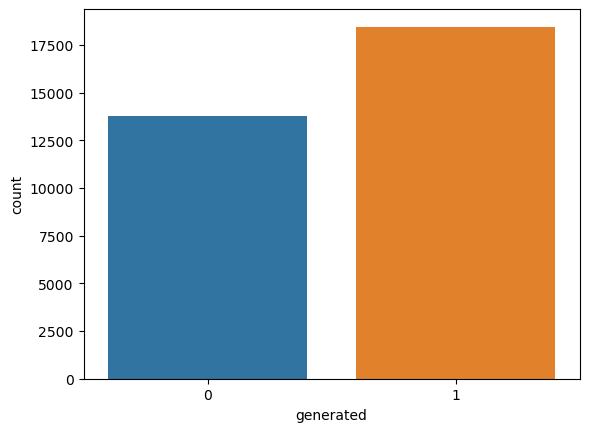

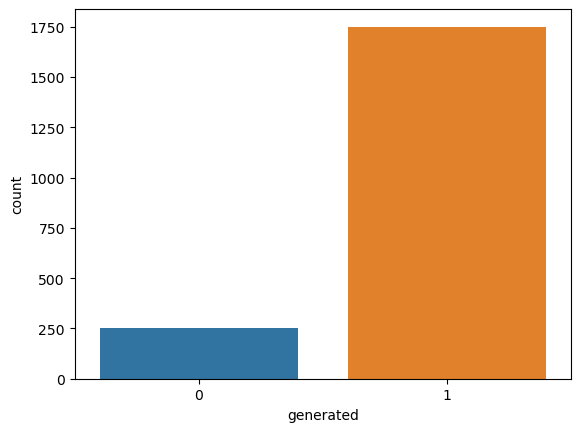

(3378, 4)


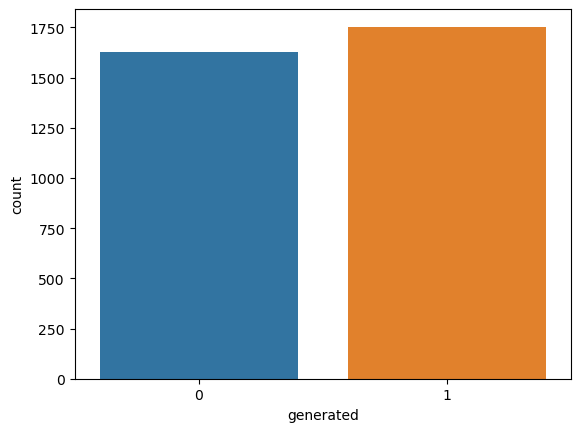

(2364, 4) (1014, 4)


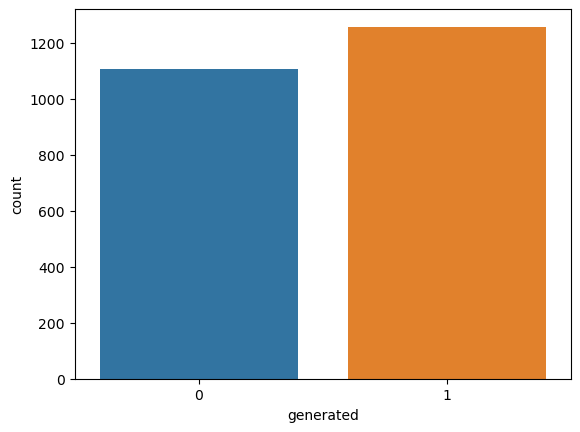

In [2]:
# Load the training and testing datasets
train_essays = pd.read_csv("./llm-detect-ai-generated-text/train_essays.csv")
test_essays = pd.read_csv("./llm-detect-ai-generated-text/test_essays.csv")

# Load the external dataset
exter_data1 = pd.read_csv('daigt-proper-train-dataset/train_drcat_04.csv')[['text','label','source']]
exter_data2 = pd.read_csv('argugpt/argugpt.csv', usecols=['text'])
exter_data1.rename(columns={'label':'generated'}, inplace=True)
exter_data2['generated'] = 1

ext_df = pd.concat([
    exter_data1[exter_data1.source=='persuade_corpus'].sample(10000),
    exter_data1[exter_data1.source!='persuade_corpus'],
    exter_data2
])
ext_df = ext_df[['text', 'generated']]
ext_df.info()

# Check for class balance
sns.countplot(data=ext_df, x='generated')
plt.show()

# Pick 250 data with label 0 and 1750 data with label 1
ext_df = pd.concat([
    ext_df[ext_df.generated==0].sample(250),
    ext_df[ext_df.generated==1].sample(1750)
])

del exter_data1, exter_data2
gc.collect()

# Check for class balance
sns.countplot(data=ext_df, x='generated')
plt.show()

# Combine train_essays with external data
train_essays = pd.concat([train_essays, ext_df])
print(train_essays.shape)
# Check for class balance
sns.countplot(data=train_essays, x='generated')
plt.show()

# Split the training data into training and validation sets
train_essays, val = train_test_split(train_essays, test_size=0.3, random_state=42)
print(train_essays.shape, val.shape)

# Check for class balance
sns.countplot(data=train_essays, x='generated')
plt.show()


# BPE Tokenizer

In [3]:
# create a BPE tokenizer
raw_tokenizer = Tokenizer(models.BPE())
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)
raw_tokenizer.normalizer = normalizers.NFC()
raw_tokenizer.decoder = decoders.ByteLevel()

# set the trainer
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=30000, show_progress=True, special_tokens=special_tokens)

text_data = pd.concat([train_essays[['text']], val[['text']]])
dataset = Dataset.from_pandas(text_data)

def train_corp_iter(): 
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]

raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

tokenized_texts_test = []

for text in tqdm(test_essays['text'].tolist()):
    tokenized_texts_test.append(tokenizer.tokenize(text))

tokenized_texts_train = []

for text in tqdm(train_essays['text'].tolist()):
    tokenized_texts_train.append(tokenizer.tokenize(text))

tokenized_texts_val = []

for text in tqdm(val['text'].tolist()):
    tokenized_texts_val.append(tokenizer.tokenize(text))




huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 1014/1014 [00:00<00:00, 1096.26it/s]


# TF-IDF Vectorization

In [4]:
# Convert the tokenized text to a vector of token counts
def dummy(text):
    return text
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer = 'word',
    tokenizer = dummy,
    preprocessor = dummy,
    token_pattern = None, strip_accents='unicode')

# Getting vocab
vectorizer.fit(tokenized_texts_val)
vocab = vectorizer.vocabulary_


vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
                            analyzer = 'word',
                            tokenizer = dummy,
                            preprocessor = dummy,
                            token_pattern = None, strip_accents='unicode'
                            )

tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)
tf_val = vectorizer.transform(tokenized_texts_val)

del vectorizer
gc.collect()

y_train = train_essays['generated'].values

In [7]:
print(tf_train)
print(tf_train.shape)

  (0, 3166879)	0.02964107951428677
  (0, 3166878)	0.02964107951428677
  (0, 3166877)	0.028529307023963852
  (0, 3166812)	0.031208034831101027
  (0, 3166810)	0.028529307023963852
  (0, 3166809)	0.028529307023963852
  (0, 3166682)	0.031208034831101027
  (0, 3166681)	0.031208034831101027
  (0, 3166680)	0.031208034831101027
  (0, 3166620)	0.026366622944019077
  (0, 3166619)	0.026366622944019077
  (0, 3166607)	0.021604896092875237
  (0, 3164320)	0.031208034831101027
  (0, 3164319)	0.031208034831101027
  (0, 3164318)	0.031208034831101027
  (0, 3164304)	0.031208034831101027
  (0, 3164303)	0.031208034831101027
  (0, 3164302)	0.031208034831101027
  (0, 3164190)	0.031208034831101027
  (0, 3164188)	0.031208034831101027
  (0, 3164187)	0.031208034831101027
  (0, 3163926)	0.031208034831101027
  (0, 3163925)	0.031208034831101027
  (0, 3163924)	0.031208034831101027
  (0, 3163780)	0.031208034831101027
  :	:
  (2363, 102399)	0.03088285926730756
  (2363, 95210)	0.03088285926730756
  (2363, 95209)	0.03088

# Model Creating and Training

Fitting 5 folds for each of 7 candidates, totalling 35 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

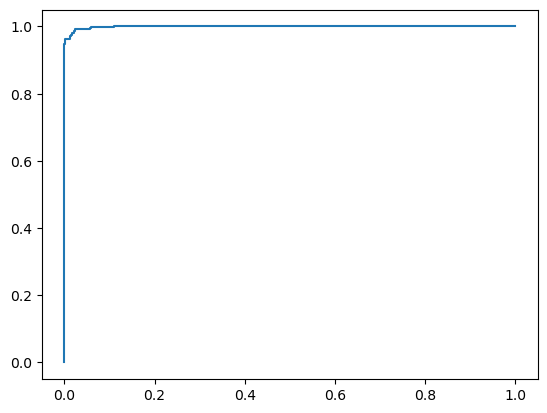

In [8]:
sub = pd.read_csv('llm-detect-ai-generated-text/sample_submission.csv')
if len(test_essays.text.values) <= 2:
    sub.to_csv('submission.csv', index=False)
else:
    # Create a SGD classifier
    sgd = SGDClassifier(loss='modified_huber', random_state=42, max_iter=1000, tol=1e-3, n_jobs=-1)

    # Create a Multinomial Naive Bayes classifier
    mnb = MultinomialNB()

    # Create a LightGBM classifier
    lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

    # Create a Voting Classifier
    ensemble = VotingClassifier(estimators=[('sgd', sgd), ('mnb', mnb), ('lgbm', lgbm)], voting='soft', n_jobs=-1)

    param_grid = {
        'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2], [2, 2, 1], [2, 1, 2], [1, 2, 2]] # weights for VotingClassifier
    }

    # Create grid search object
    grid = GridSearchCV(estimator=ensemble, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1)

    # Fit the model
    grid.fit(tf_train, y_train)

    # Create grid search object
    grid = GridSearchCV(estimator=ensemble, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1)

    # Fit the model
    grid.fit(tf_train, y_train)
    gc.collect()

    # Print the best parameters
    print(grid.best_params_['weights'])

    # Get the best estimator
    best_ensemble = grid.best_estimator_

    # Predict the test set
    final_preds = best_ensemble.predict_proba(tf_test)[:,1]

    sub['generated'] = final_preds
    sub['id'] = test_essays['id']
    sub.to_csv('submission.csv', index=False)
print(sub.head())

# test on the validation set
val_preds = best_ensemble.predict_proba(tf_val)[:,1]
print(roc_auc_score(val['generated'], val_preds))
print(accuracy_score(val['generated'], val_preds.round()))

# draw the roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(val['generated'], val_preds)
plt.plot(fpr, tpr)

